In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
img_path = r'./Image/img.png'
image = plt.imread(img_path)

### 1. Giảm nhiễu
- Chuyển đổi ảnh ban đầu thành ảnh đa mức xám
- Sử dụng Gaussian filter kernal 5x5 để giảm nhiễu cho ảnh gốc

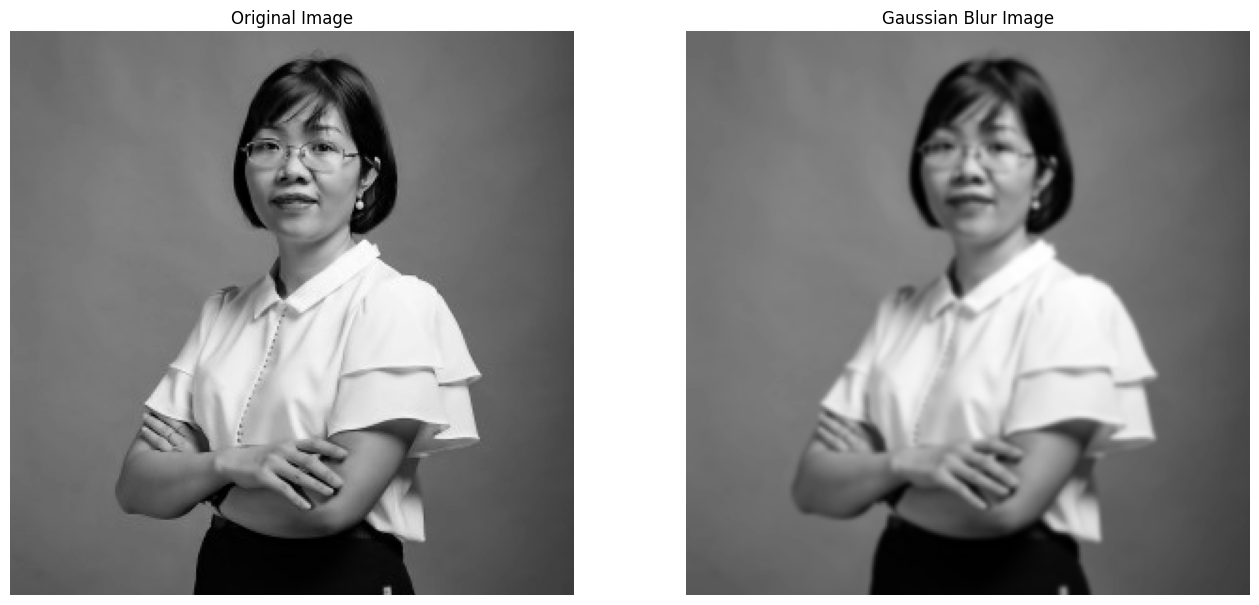

In [4]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gau_image = cv2.GaussianBlur(gray_image, (5,5), 0)
fix, axs = plt.subplots(1,2, figsize=(16,8))
axs[0].imshow(gray_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Original Image")
axs[1].imshow(gau_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Gaussian Blur Image")
plt.show()

### 2. Áp dụng Sobel kernal
Sử dụng Sobel kernal theo hướng x và hướng y để làm nổi bật đường biên của đối tượng. Sau đó, tính toán độ lớn cường độ pixel tại từng pixel ảnh cũng như độ dốc (hướng) của pixel đang được xử lý.

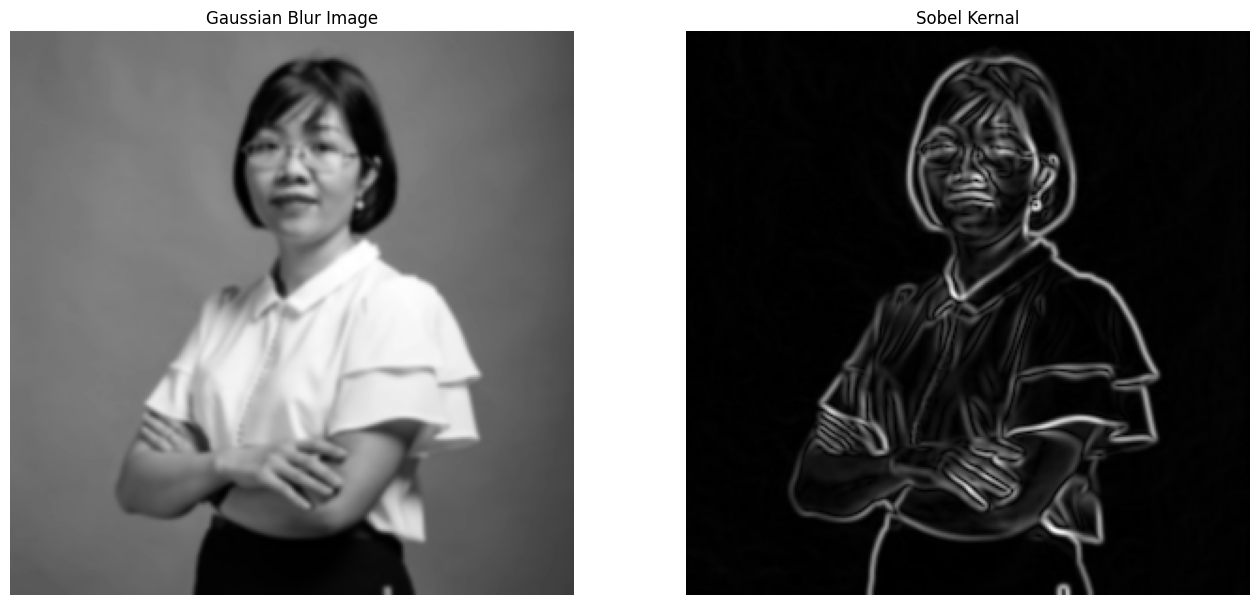

In [5]:
# Áp dụng mặt nạ Sobel kernel
gradient_x = cv2.Sobel(gau_image, cv2.CV_32F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(gau_image, cv2.CV_32F, 0, 1, ksize=3)

# Tính độ lớn độ dốc
gradient_magnitude = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
#Hướng của biên
gradient_direction = np.arctan2(gradient_x, gradient_y)
# Hiển thị biên
fix, axs = plt.subplots(1,2, figsize=(16,8))
axs[0].imshow(gau_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Gaussian Blur Image")
axs[1].imshow(gradient_magnitude, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Sobel Kernal")
plt.show()

### 3. Loại bỏ những điểm không cực đại
Loại bỏ những điểm không cực đại dựa theo hướng của Gradient vector được tính ở bước thứ 2 nhằm cân đối độ dày đường biên Việc làm mỏng này là vô cùng quan trọng nhé!

In [6]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = (D * 180.) / np.pi #Chuyển đổi radian qua đơn vị độ
    angle[angle < 0] += 180 # Đảm bảo góc nằm trong khoảng [0,180]

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            try:
                q = 255
                r = 255

                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = img[i + 1, j]
                    r = img[i - 1, j]
                # angle 45
                elif (22.5 <= angle[i, j] < 67.5):
                    q = img[i - 1, j - 1]
                    r = img[i + 1, j + 1]
                # angle 90
                elif (67.5 <= angle[i, j] < 112.5):
                    q = img[i, j -1]
                    r = img[i, j +1]
                # angle 135
                elif (112.5 <= angle[i, j] < 157.5):
                    q = img[i - 1, j + 1]
                    r = img[i + 1, j - 1]

                if (img[i, j] < q) or (img[i, j] < r): # Nếu 2 pixel cùng hướng với vector được xét có cường độ pixel nhỏ hơn
                    Z[i, j] = 0
                else:
                    Z[i, j] = img[i, j]
            except IndexError as e:
                pass
    return Z

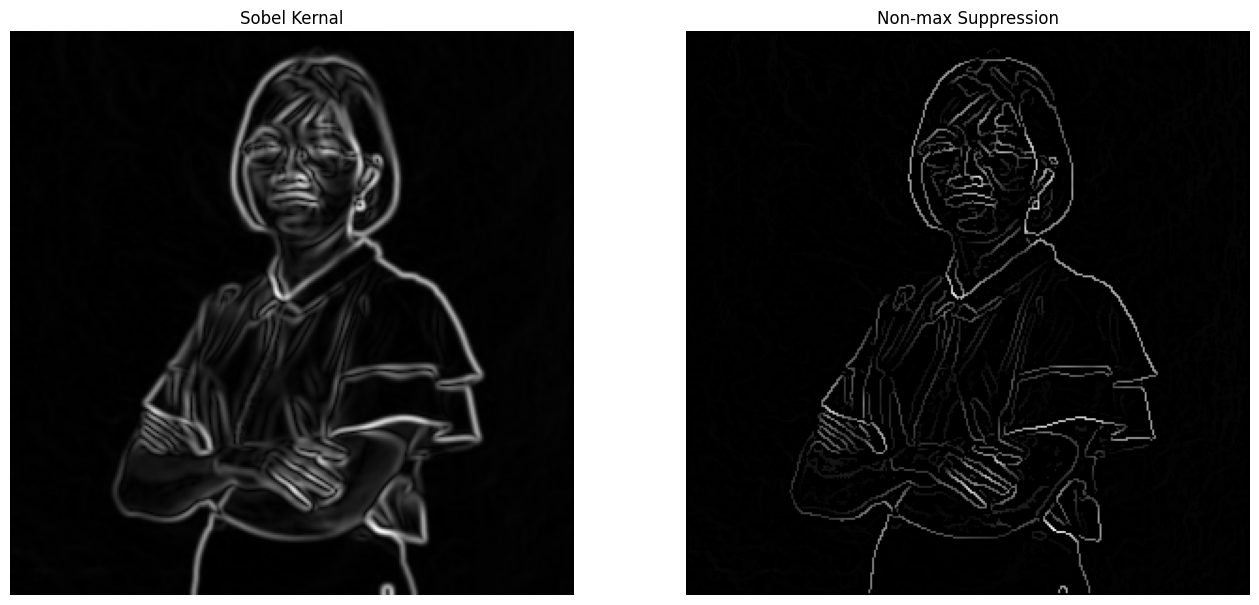

In [7]:
result_image = non_max_suppression(gradient_magnitude, gradient_direction)
fix, axs = plt.subplots(1,2, figsize=(16, 8))
axs[0].imshow(gradient_magnitude, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Sobel Kernal")
axs[1].imshow(result_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Non-max Suppression")
plt.show()

--> thấy chưa,đường biên mỏng và đẹp hơn nhiều rồi đúng không? Ban đầu làm lộn hướng nên là đường biên nó không được liên tục và đều như thế này

### 4. Hysteresis thresholding
Bước này gồm 2 phần: phần đầu là threshold sẽ làm nổi bật các đường biên lên cường độ 255. Đồng thời do đó sẽ xuất hiện nhiễu nên bước tiếp theo là Hysteresis sẽ có vai trò loại bỏ những nhiễu đấy.
Cơ chế đơn giản là xét các lân cận 3x3 của điểm weak (i,j) . Nếu trong lân cận có pixel có cường độ 255 thì đổi cường độ thành 255. Nếu không thì đổi cường độ thành 0

In [9]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):

    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)

    strong_i, strong_j = np.where(img >= highThreshold)#Tìm và gán các pixel có cường độ >= HighTh và gán vào ma trận result
    zeros_i, zeros_j = np.where(img < lowThreshold) #Tìm các pixel có cường độ < LowThreshlod, gán nó = 0 và lưu vào ma trận

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold)) # Tương tự

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res, weak, strong)

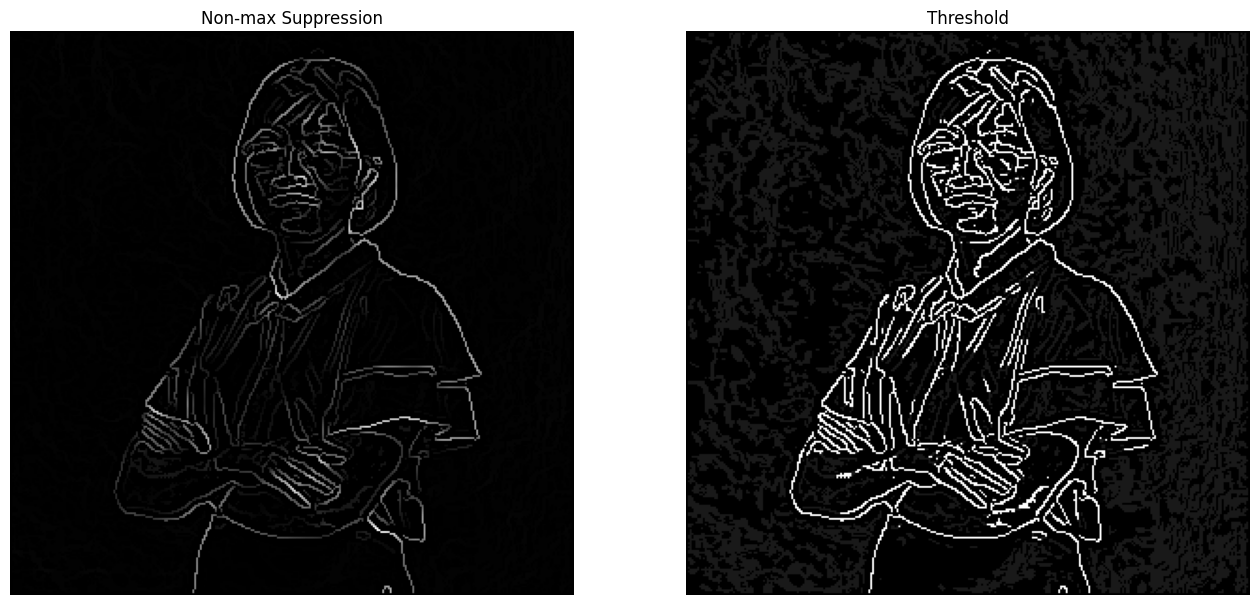

In [10]:
thres = threshold(result_image, 0.05, 0.09)[0]
fix, axs = plt.subplots(1,2, figsize=(16, 8))
axs[0].imshow(result_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Non-max Suppression")
axs[1].imshow(thres, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Threshold")
plt.show()

In [11]:
def hysteresis(img, low_threshold, high_threshold):
    M, N = img.shape
    weak = 100  # Giá trị weak có thể được điều chỉnh tùy theo yêu cầu

    strong = 255
    result = np.zeros((M, N), dtype=np.uint8)

    # Loại bỏ các điểm yếu không đạt được high_threshold
    strong_pixels = (img >= high_threshold)
    result[strong_pixels] = strong

    # Duyệt qua các điểm yếu và kiểm tra xem có kết nối với các điểm mạnh không
    for i in range(1, M - 1):
        for j in range(1, N - 1):
            if img[i, j] >= low_threshold and result[i, j] == 0:
                neighbors = result[i - 1:i + 2, j - 1:j + 2]
                if np.max(neighbors) == strong:
                    result[i, j] = strong
                else:
                    result[i, j] = weak

    return result


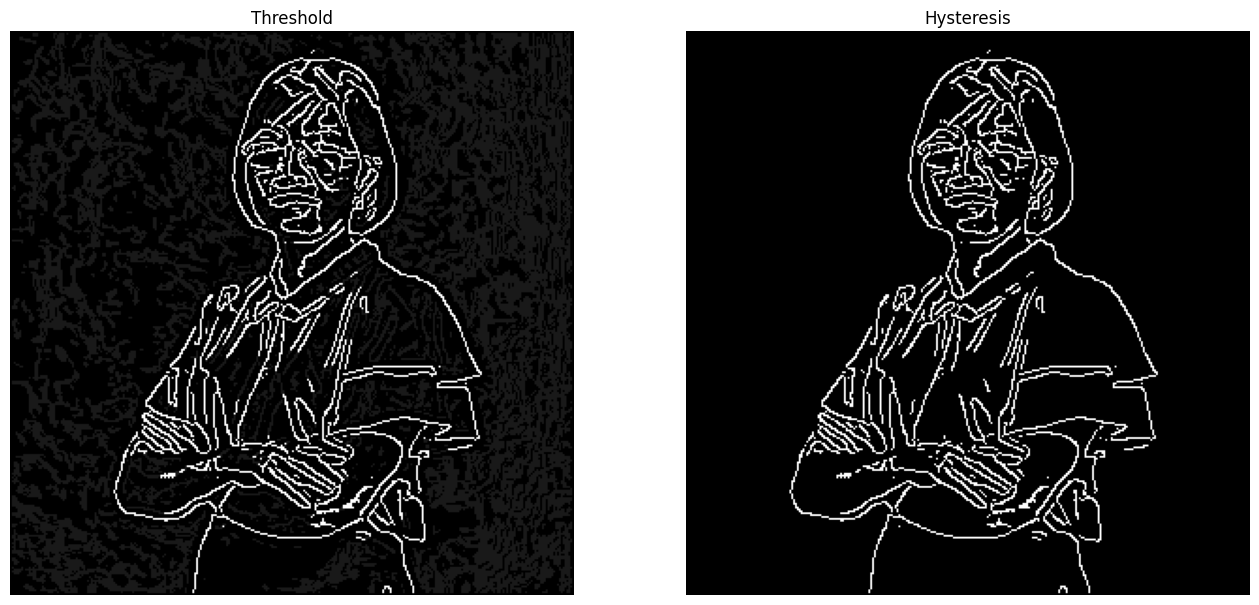

In [12]:
hyst = hysteresis(thres, 70, 200)
fix, axs = plt.subplots(1,2, figsize=(16, 8))
axs[0].imshow(thres, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Threshold")
axs[1].imshow(hyst, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Hysteresis")
plt.show()


### 5. So sánh
Hình dưới là so sánh kết quả sau khi thu được với hàm Canny của thư viện OpenCV. Kết quả cho thấy kết quả thu được có đường biên mỏng hơn và đều hơn so với Canny function của OpenCV. Tuy nhiên, các đừng biên ngắn và không liên tục vẫn chưa được xử lý tốt bằng Canny function

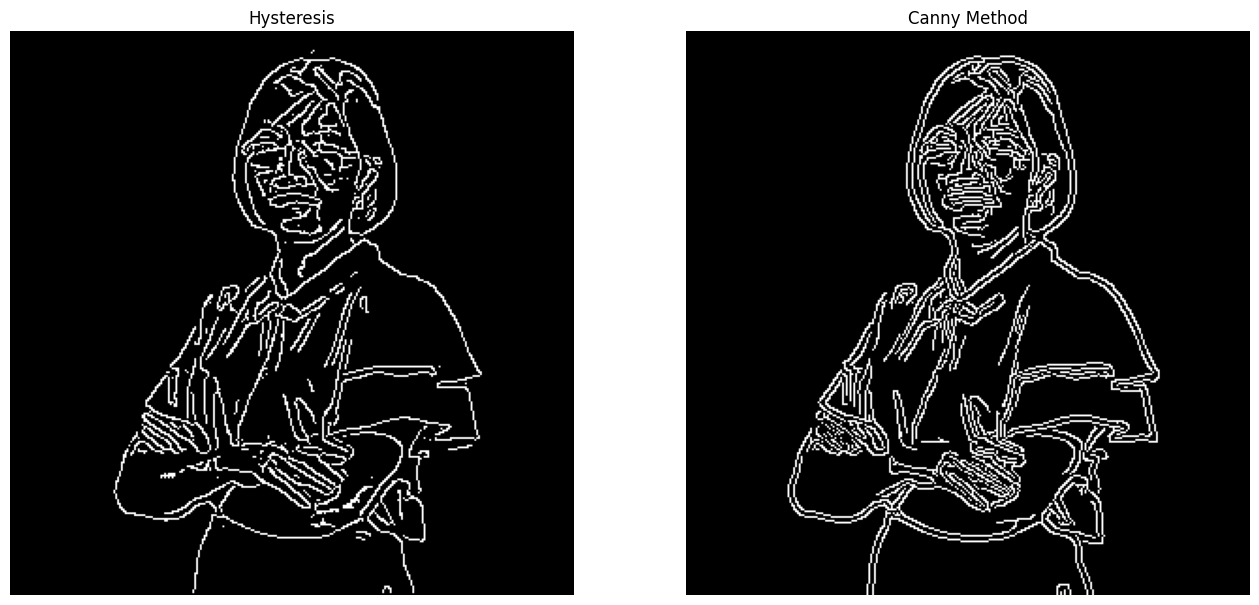

In [24]:
edges = cv2.Canny(gradient_magnitude, 70,200)
fix, axs = plt.subplots(1,2, figsize=(16, 8))
axs[0].imshow(hyst, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Hysteresis")
axs[1].imshow(edges, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Canny Method")
plt.show()

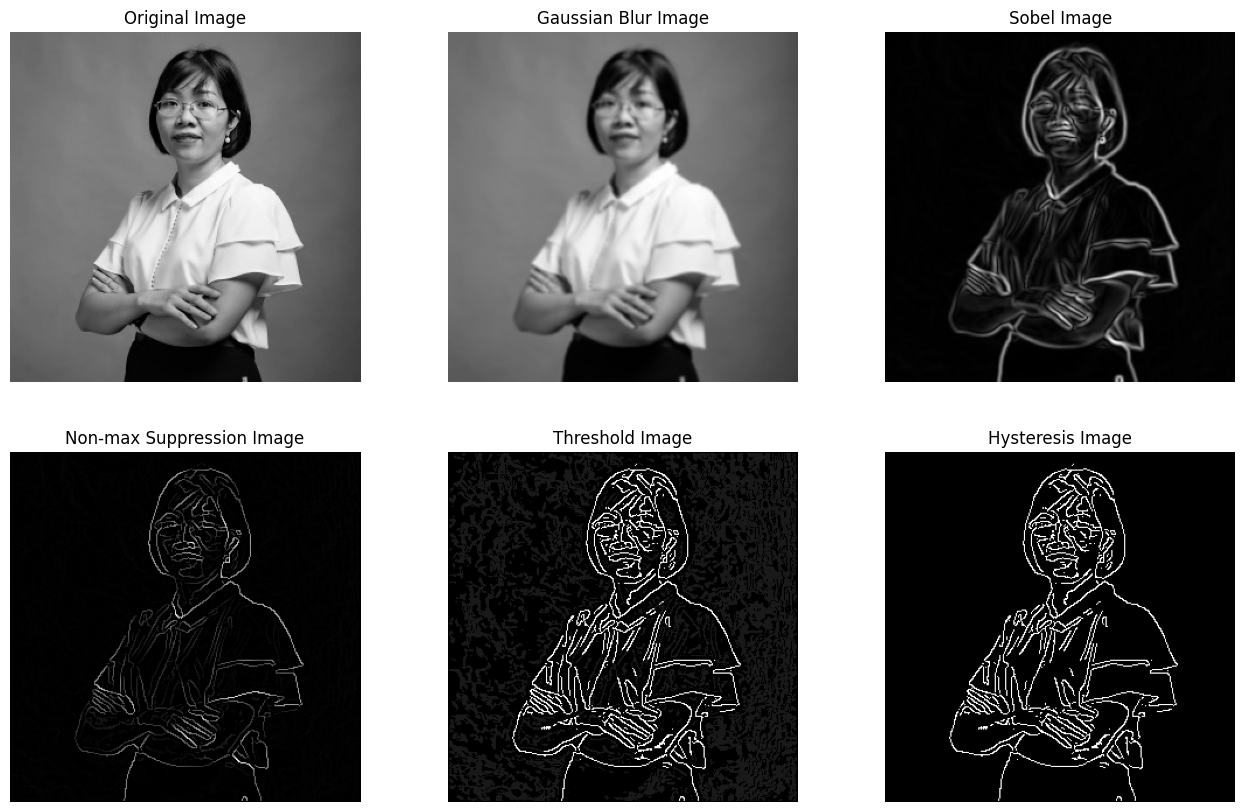

In [17]:
fix, axs = plt.subplots(2,3, figsize=(16, 10))
axs[0,0].imshow(gray_image, cmap='gray')
axs[0,0].axis('off')
axs[0,0].set_title("Original Image")
axs[0,1].imshow(gau_image, cmap='gray')
axs[0,1].axis('off')
axs[0,1].set_title("Gaussian Blur Image")
axs[0,2].imshow(gradient_magnitude, cmap='gray')
axs[0,2].axis('off')
axs[0,2].set_title("Sobel Image")
axs[1,0].imshow(result_image, cmap='gray')
axs[1,0].axis('off')
axs[1,0].set_title("Non-max Suppression Image")
axs[1,1].imshow(thres, cmap='gray')
axs[1,1].axis('off')
axs[1,1].set_title("Threshold Image")
axs[1,2].imshow(hyst, cmap='gray')
axs[1,2].axis('off')
axs[1,2].set_title("Hysteresis Image")
plt.show()